# Bloco de imports, e criação da engine do sqlalchemy:

In [1]:
import requests as r
import json
import pandas as pd
from datetime import datetime, timedelta, timezone, date
import numpy as np
import pandas as pd
import numpy as np
import psycopg2
import time
import os
import threading
import subprocess
import logging
import traceback
import smtplib
import gspread
from sqlalchemy import create_engine, text
from google.oauth2 import service_account
from openpyxl import load_workbook
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from adsim_config import adsim_token, host, port, dbname, user, password
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

engine = create_engine(f"postgresql://{user}:{password}@{host}:{port}/{dbname}")

# Análise de Tempo de Fechamento de negócios no CRM, uma análise descritiva.

In [2]:
deals = pd.read_sql_query("SELECT * FROM deals", engine)

deals.head()

,main_id,pipeline_id,creatoruser_id,responsible_id,pipelinestep_id,organization_id,product_id,dealtype_id,person_id,agencies_id,...,conversiondate,lastupdatedate,negotiatedvalue,productquantity,forecastsalesdate,isadvancedproduct,activitiesquantity,hasproductswithquotas,agencycommissionpercentage,company_id
0,1320951,1077,23189,17266,6018,914251.0,25546.0,229.0,NaN,1127005.0,...,None,2025-01-10 16:08:06,2469.00,1,None,False,0,False,0,367.0
1,1320648,1077,23189,24253,6804,916856.0,29826.0,229.0,1134398.0,NaN,...,None,2025-01-13 10:39:39,18000.00,1,None,False,0,False,0,367.0
2,1320590,1077,22676,22676,6018,1100087.0,NaN,230.0,1100088.0,1137329.0,...,None,2025-01-22 11:56:03,54314.82,2,None,False,0,False,0,367.0
3,1320521,1077,22933,22933,6018,1135084.0,NaN,229.0,1135088.0,NaN,...,None,2025-02-06 14:36:02,12000.00,1,None,False,0,False,0,367.0
4,1344529,1077,17295,17295,6805,914447.0,35720.0,229.0,NaN,NaN,...,None,2025-03-31 14:51:12,63861.73,1,None,False,0,False,0,367.0


In [3]:
deals['windate'] = pd.to_datetime(deals['windate'])
deals['registerdate'] = pd.to_datetime(deals['registerdate'])

deals.head()

,main_id,pipeline_id,creatoruser_id,responsible_id,pipelinestep_id,organization_id,product_id,dealtype_id,person_id,agencies_id,...,conversiondate,lastupdatedate,negotiatedvalue,productquantity,forecastsalesdate,isadvancedproduct,activitiesquantity,hasproductswithquotas,agencycommissionpercentage,company_id
0,1320951,1077,23189,17266,6018,914251.0,25546.0,229.0,NaN,1127005.0,...,None,2025-01-10 16:08:06,2469.00,1,None,False,0,False,0,367.0
1,1320648,1077,23189,24253,6804,916856.0,29826.0,229.0,1134398.0,NaN,...,None,2025-01-13 10:39:39,18000.00,1,None,False,0,False,0,367.0
2,1320590,1077,22676,22676,6018,1100087.0,NaN,230.0,1100088.0,1137329.0,...,None,2025-01-22 11:56:03,54314.82,2,None,False,0,False,0,367.0
3,1320521,1077,22933,22933,6018,1135084.0,NaN,229.0,1135088.0,NaN,...,None,2025-02-06 14:36:02,12000.00,1,None,False,0,False,0,367.0
4,1344529,1077,17295,17295,6805,914447.0,35720.0,229.0,NaN,NaN,...,None,2025-03-31 14:51:12,63861.73,1,None,False,0,False,0,367.0


In [4]:
#deals = deals[deals['registerdate'].dt.year == 2025]
deals = deals[deals['iswon'] == True]
deals = deals.dropna(subset=['windate'])

deals['time_difference'] = deals['windate'] - deals['registerdate']

average_time_difference = deals['time_difference'].mean()

deals.head()

,main_id,pipeline_id,creatoruser_id,responsible_id,pipelinestep_id,organization_id,product_id,dealtype_id,person_id,agencies_id,...,lastupdatedate,negotiatedvalue,productquantity,forecastsalesdate,isadvancedproduct,activitiesquantity,hasproductswithquotas,agencycommissionpercentage,company_id,time_difference
0,1320951,1077,23189,17266,6018,914251.0,25546.0,229.0,NaN,1127005.0,...,2025-01-10 16:08:06,2469.00,1,None,False,0,False,0,367.0,0 days 01:06:21
2,1320590,1077,22676,22676,6018,1100087.0,NaN,230.0,1100088.0,1137329.0,...,2025-01-22 11:56:03,54314.82,2,None,False,0,False,0,367.0,12 days 20:43:36
3,1320521,1077,22933,22933,6018,1135084.0,NaN,229.0,1135088.0,NaN,...,2025-02-06 14:36:02,12000.00,1,None,False,0,False,0,367.0,28 days 03:17:54
11,1344463,1077,17265,17295,6018,1112780.0,32108.0,229.0,NaN,1105095.0,...,2025-03-13 10:34:58,5835.97,1,None,False,0,False,20,367.0,0 days 00:39:01
18,1345038,1207,18111,18111,6704,914735.0,34522.0,419.0,NaN,NaN,...,2025-03-28 09:20:46,29000.00,1,None,False,0,False,0,NaN,13 days 22:32:24


In [5]:
median_time_difference = deals['time_difference'].median()
mode_time_difference = deals['time_difference'].mode()
dp_time_difference = deals['time_difference'].std()
deals['total_horas'] = deals['time_difference'].dt.total_seconds() / 3600
#variance_time_difference = np.var(deals['time_difference'])


print(f"a média de dias para um negócio ser ganho é: {average_time_difference}")
print(f"a mediana de dias para um negócio ser ganho é: {median_time_difference}")
#print(f"a moda de dias para um negócio ser ganho é: {mode_time_difference}")
print(f"o desvio padrao de dias para um negócio ser ganho é: {dp_time_difference}")

a média de dias para um negócio ser ganho é: 3 days 20:02:46.377211606
a mediana de dias para um negócio ser ganho é: 0 days 16:55:10
o desvio padrao de dias para um negócio ser ganho é: 9 days 22:03:49.546261286


## Análise Gráfica por Pipeline:

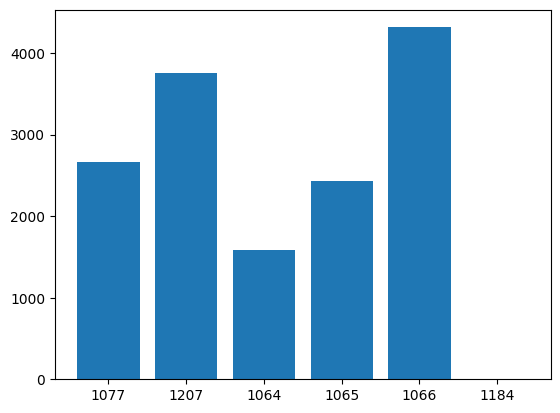

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

deals['pipeline_id'] = deals['pipeline_id'].astype(str)

ax.bar(deals['pipeline_id'], deals['total_horas'])

plt.show()



Temos que a unidade de negócio de Londrina (1066) tem o maior tempo em horas para fechar um negócio, para entender o comportamento, iremos performar outras análises, comparando com a unidade de negócio de Curitiba (1077)

## Análise Descritiva por Unidade de Negócio:

In [7]:
from scipy import stats

stats.pearsonr(deals['negotiatedvalue'], deals['total_horas'])

#A correlação entre essas duas variáveis é muito baixa, ou seja, nos indica que o valor de um negócio (ou sua complexidade) não tem correlação com o tempo de fechamento.

PearsonRResult(statistic=nan, pvalue=nan)

In [8]:
deals_londrina = deals[deals['pipeline_id'] == '1066']
deals_curitiba = deals[deals['pipeline_id'] == '1077']

#estamos inicializando as váriaveis para performarmos os cálculos de tempo médio, entre outros.

In [9]:
median_curitiba_time = deals_curitiba['time_difference'].mean()
sd_curitiba_time = deals_curitiba['time_difference'].std()

print(f"a média de tempo para fechar um negócio em curitiba é de: {median_curitiba_time}")
print(f"o desvio padrao de tempo para fechar um negócio em curitiba é de: {sd_curitiba_time}")

a média de tempo para fechar um negócio em curitiba é de: 3 days 13:34:48.613483146
o desvio padrao de tempo para fechar um negócio em curitiba é de: 8 days 16:22:28.399407378


In [10]:
median_londrina_time = deals_londrina['time_difference'].mean()
sd_londrina_time = deals_londrina['time_difference'].std()

print(f"a média de tempo para fechar um negócio em londrina é de: {median_londrina_time}")
print(f"o desvio padrao de tempo para fechar um negócio em londrina é de: {sd_londrina_time}")

a média de tempo para fechar um negócio em londrina é de: 4 days 01:14:24.403883495
o desvio padrao de tempo para fechar um negócio em londrina é de: 12 days 18:28:15.306839813


ou seja, o comportamento de lançamento de negócios é bem diferente entre as duas unidades de negócio, nos mostrando que existe sim um comportamento que pode ser dito como pior ou melhor no uso do CRM.

temos um péssimo comportamento de CRM aqui, ambas as unidades de negócio não refletem a realidade da área de atuação da empresa.

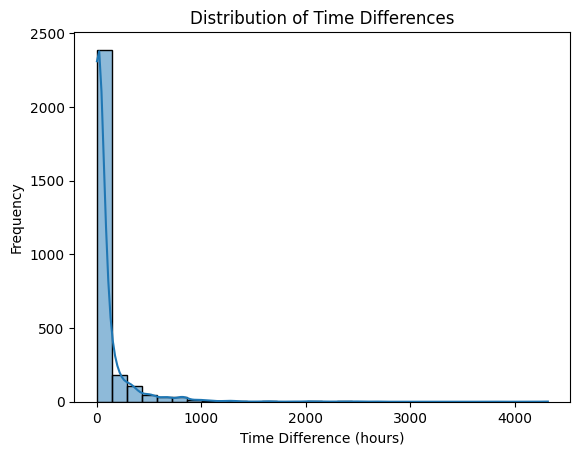

In [ ]:
#aqui, vamos entender como está a distribuição da diferença de tempo, para entendermos como é o comportamento da maioria.

deals['responsible_id'].astype(str)

sns.histplot(deals['total_horas'], kde=True, bins=30)
plt.title('Distribution of Time Differences')
plt.xlabel('Time Difference (hours)')
plt.ylabel('Frequency')
plt.show()

No gráfico acima, podemos ver que a maioria dos negócios levam menos que uma hora para serem fechados, ou seja, o comportamento padrão do vendedor é de inserir o negócio que já está fechado, sem apresentar uma verdadeira jornada de sua venda.

C:\Users\guilherme.oliveira\AppData\Local\Temp\ipykernel_14772\1918983504.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deals_curitiba['responsible_id'] = deals_curitiba['responsible_id'].astype(str)


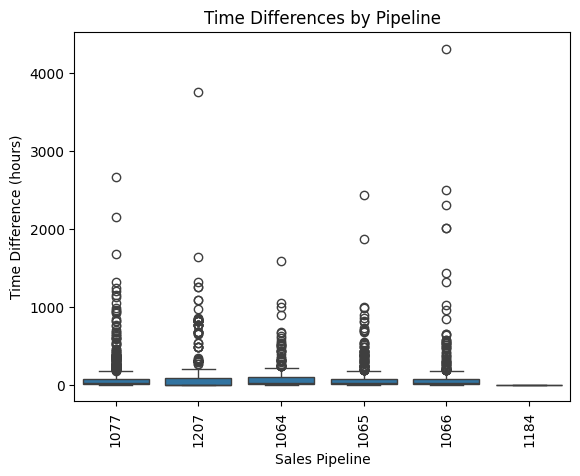

In [12]:
deals_curitiba['responsible_id'] = deals_curitiba['responsible_id'].astype(str)

sns.boxplot(x='pipeline_id', y='total_horas', data=deals)
plt.title('Time Differences by Pipeline')
plt.xlabel('Sales Pipeline')
plt.ylabel('Time Difference (hours)')
plt.xticks(rotation=90)
plt.show()

O box-plot acima nos mostra que a distribuição por pipeline está muito parecida, o que infelizmente implica que o problema é de toda a empresa e não de uma unidade de negócio única. Os círculos representam os outliers, como podemos ver, o comportamento (correto) é um outlier.

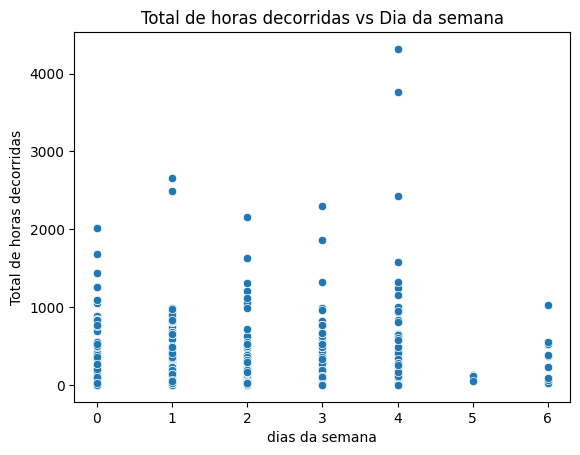

In [13]:
deals['day_inserted'] = deals['registerdate'].dt.dayofweek

sns.scatterplot(x='day_inserted', y='total_horas', data=deals)
plt.title('Total de horas decorridas vs Dia da semana')
plt.xlabel('dias da semana')
plt.ylabel('Total de horas decorridas')
plt.show()

esse gráfico foi uma tentativa para identificar se o comportament varia por dia da semana, podemos ver que negócios criados na sexta feira levam muito menos tempo a serem fechados, comprovando o ponto de que negócios inseridos na ferramenta não apresentam uma jornada de venda.

## Outliers:

In [14]:
Q1 = deals['total_horas'].quantile(0.25)
Q3 = deals['total_horas'].quantile(0.75)
IQR = Q3 - Q1

outliers = deals[(deals['total_horas'] < (Q1 - 1.5 * IQR)) | (deals['total_horas'] > (Q3 + 1.5 * IQR))]
print("Outliers:\n", outliers)

Outliers:
       main_id pipeline_id  creatoruser_id  responsible_id  pipelinestep_id  \
2     1320590        1077           22676           22676             6018   
3     1320521        1077           22933           22933             6018   
18    1345038        1207           18111           18111             6704   
65    1346473        1065           19736           19736             5949   
111   1351055        1077           23189           17263             6018   
...       ...         ...             ...             ...              ...   
8767  1339552        1077           23545           23545             6018   
8781  1337691        1066           25118           25118             5953   
8839  1343576        1066           18119           18119             5953   
8867  1343586        1066           18119           18119             5953   
8913  1348032        1066           18119           18119             5953   

      organization_id  product_id  dealtype_id  pers

Um dataframe contendo todos os outliers no ano de 2025, infelizmente, são os mais próximos de nossa realidade atual de venda. O que deveria de ser o contrário.

# Decision Tree em um ambiente de negócios:

In [ ]:
#Carrega algumas bases de dados como dataframes para as análises futuras.

dues = pd.read_sql_query("SELECT * FROM dues", engine)
users = pd.read_sql_query("SELECT * FROM users", engine)
logs = pd.read_sql_query("SELECT * FROM historico", engine)
sales = pd.read_sql_query("SELECT * FROM sales", engine)
pipelinestep = pd.read_sql_query("SELECT * FROM pipelinestep", engine)

In [ ]:
#Inicializa um dataframe vazio, onde iremos armazenar nossas features para treinamento e teste do modelo

df = pd.DataFrame()

## Feature Engineering:

In [ ]:
temp_logs = logs[logs['pipelinestep_id'].isin([6814, 6805, 6811, 6807, 6862, 6826, 6863, 6808, 6827, 6812, 6563, 6562, 6809, 6815, 6290, 6142, 6864, 6295, 6289, 6703])] #Etapas fora de fechados.
temp_logs['enterdate'] = pd.to_datetime(temp_logs['enterdate'])
temp_logs_lm = temp_logs[temp_logs['enterdate'].dt.month == 3] #Mês de Março
temp_dues = dues[dues['main_id'].isin(temp_logs['main_id'])]
temp_dues = temp_dues.groupby(['user_id', 'channel_id'],dropna=False, as_index=False)['netvalue'].sum()

df['user_id'] = temp_dues['user_id'] # Aqui temos o ID do usuário, para caso a análise seja necessária de utilizar essa feature.
df['channel_id'] = temp_dues['channel_id'] # ID do veículo de venda
df['proposal_volume_lm'] = temp_dues['netvalue'] # Volume de propostas em dinheiro, ou seja, quanto os vendedores estavam com negócios circulando.

C:\Users\guilherme.oliveira\AppData\Local\Temp\ipykernel_14772\1566927258.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_logs['enterdate'] = pd.to_datetime(temp_logs['enterdate'])


In [ ]:
temp_dues = dues[dues['main_id'].isin(deals['main_id'])] #Aqui, estamos filtrando apenas os negócios fechados.
temp_dues['duedate'] = pd.to_datetime(temp_dues['duedate'])
temp_dues = temp_dues[temp_dues['duedate'].dt.month == 3] #No mês de Março
temp_dues = temp_dues.groupby(['user_id', 'channel_id'],dropna=False, as_index=False)['netvalue'].sum()

#Adicionamos aqui uma coluna contendo o faturamento do mês vigente. Para compararmos com o que foi basquetado.
df['revenue_lm'] = df.merge(temp_dues[['netvalue', 'channel_id', 'user_id']], how='left', on=['channel_id', 'user_id'])['netvalue'] 

C:\Users\guilherme.oliveira\AppData\Local\Temp\ipykernel_14772\1628055372.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_dues['duedate'] = pd.to_datetime(temp_dues['duedate'])


In [ ]:
df['convertion_rate_lm'] = df['revenue_lm'] / df['proposal_volume_lm'] #Taxa de conversão

In [ ]:
# Mesmo trabalho de filtros, agora, estamos olhando ao faturamento do mês atual.

temp_dues = dues[dues['main_id'].isin(deals['main_id'])]
temp_dues['duedate'] = pd.to_datetime(temp_dues['duedate'])
temp_dues = temp_dues[temp_dues['duedate'].dt.month == 4]
temp_dues = temp_dues.groupby(['user_id', 'channel_id'],dropna=False, as_index=False)['netvalue'].sum()

df['revenue_cm'] = df.merge(temp_dues[['netvalue', 'channel_id', 'user_id']], how='left', on=['channel_id', 'user_id'])['netvalue']

C:\Users\guilherme.oliveira\AppData\Local\Temp\ipykernel_14772\2499945483.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_dues['duedate'] = pd.to_datetime(temp_dues['duedate'])


In [ ]:
# Mesmo trabalho de filtros, agora, estamos olhando ao volume de propostas do mês atual.

temp_logs = logs[logs['pipelinestep_id'].isin([6814, 6805, 6811, 6807, 6862, 6826, 6863, 6808, 6827, 6812, 6563, 6562, 6809, 6815, 6290, 6142, 6864, 6295, 6289, 6703])]
temp_logs['enterdate'] = pd.to_datetime(temp_logs['enterdate'])
temp_logs_lm = temp_logs[temp_logs['enterdate'].dt.month == 4]
temp_dues = dues[dues['main_id'].isin(temp_logs['main_id'])]
temp_dues = temp_dues.groupby(['user_id', 'channel_id'],dropna=False, as_index=False)['netvalue'].sum()

df['proposal_volume_cm'] = df.merge(temp_dues[['netvalue', 'channel_id', 'user_id']], how='left', on=['channel_id', 'user_id'])['netvalue']

C:\Users\guilherme.oliveira\AppData\Local\Temp\ipykernel_14772\845393367.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_logs['enterdate'] = pd.to_datetime(temp_logs['enterdate'])


In [ ]:
df['convertion_rate_cm'] = df['revenue_cm'] / df['proposal_volume_cm'] #Taxa de conversão.

In [ ]:
sales['mes_ano'] = pd.to_datetime(sales['mes_ano'])
temp_sales = sales[sales['mes_ano'].dt.month == 3]
temp_sales = temp_sales.groupby(['user_id', 'channel_id'], dropna=False, as_index=False)['meta'].sum()

df['goal_lm'] = df.merge(temp_sales[['meta', 'channel_id', 'user_id']], how='left', on=['channel_id', 'user_id'])['meta'] #Meta de Vendas do mês anterior.

In [ ]:
sales['mes_ano'] = pd.to_datetime(sales['mes_ano'])
temp_sales = sales[sales['mes_ano'].dt.month == 4]
temp_sales = temp_sales.groupby(['user_id', 'channel_id'], dropna=False, as_index=False)['meta'].sum()

df['goal_cm'] = df.merge(temp_sales[['meta', 'channel_id', 'user_id']], how='left', on=['channel_id', 'user_id'])['meta'] #Meta de Vendas do mês atual.

In [ ]:
#Para definir se o usuário naquele veículo de vendas teve sua meta batida.

df['goal_met_cm'] = np.where(
    (df['goal_cm'].notna()) & (df['revenue_cm'].notna()),
    np.where(df['goal_cm'] >= df['revenue_cm'], 1, 0),
    0  # or a default value (e.g., 0)
)

In [ ]:
#Para definir se o usuário naquele veículo de vendas teve sua meta batida.

df['goal_met_lm'] = np.where(
    (df['goal_lm'].notna()) & (df['revenue_lm'].notna()),
    np.where(df['goal_lm'] >= df['revenue_lm'], 1, 0),
    0  # or a default value (e.g., 0)
)

In [ ]:
#Por decisão de negócios e funcionamento do nosso processo de coleta de dados, foi decidido substituir os valores por zero, o recomendado em alguns casos é trabalhar com mediana e outros.

df["revenue_cm"].fillna(0, inplace=True)  
df["revenue_lm"].fillna(0, inplace=True)  
df["convertion_rate_cm"].fillna(0, inplace=True)  
df["convertion_rate_lm"].fillna(0, inplace=True)  
df["goal_lm"].fillna(0, inplace=True)  
df["goal_cm"].fillna(0, inplace=True)

C:\Users\guilherme.oliveira\AppData\Local\Temp\ipykernel_14772\1129525859.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["revenue_cm"].fillna(0, inplace=True)
C:\Users\guilherme.oliveira\AppData\Local\Temp\ipykernel_14772\1129525859.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder() #O encoder, serve para categorizar variáveis que se repetem, tornando elas um pouco mais fáceis de se lidar no modelo.

df['channel_id'] = enc.fit_transform(df[['channel_id']]) #Categorizando ID de veículo.

df['user_id'] = enc.fit_transform(df[['user_id']]) #Categorizando ID de usuário.

## Preparação do Modelo:

In [ ]:
from sklearn.model_selection import train_test_split

features = ["revenue_lm", "convertion_rate_lm", "goal_met_lm", "proposal_volume_lm"] #Após alguns testes e outras validações, foi decidido que seria seguido com essas features.
target = "convertion_rate_cm" # O que iremos pedir ao modelo decidir, é a taxa de conversão do mês atual, baseado nas features do mês anterior.

X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.3, random_state=42
) #Split de treino e teste, necessário para garantir um modelo saudável e confiável.

## Declaração do Modelo e teste de R²:

In [ ]:
model = DecisionTreeRegressor(max_depth=4) #Foi selecionado a Árvore de Decisão de Regressão, modelo preditivo.
model.fit(X_train, y_train) #Treino do modelo.

score = model.score(X_test, y_test) #Teste do modelo.
print("R² score:", score)

R² score: 0.5443470278315925


Como podemos ver, o R² desse modelo é relativamente baixo, no entanto, não apresenta um overfitting.

## Representação Gráfica e em Texto do modelo:

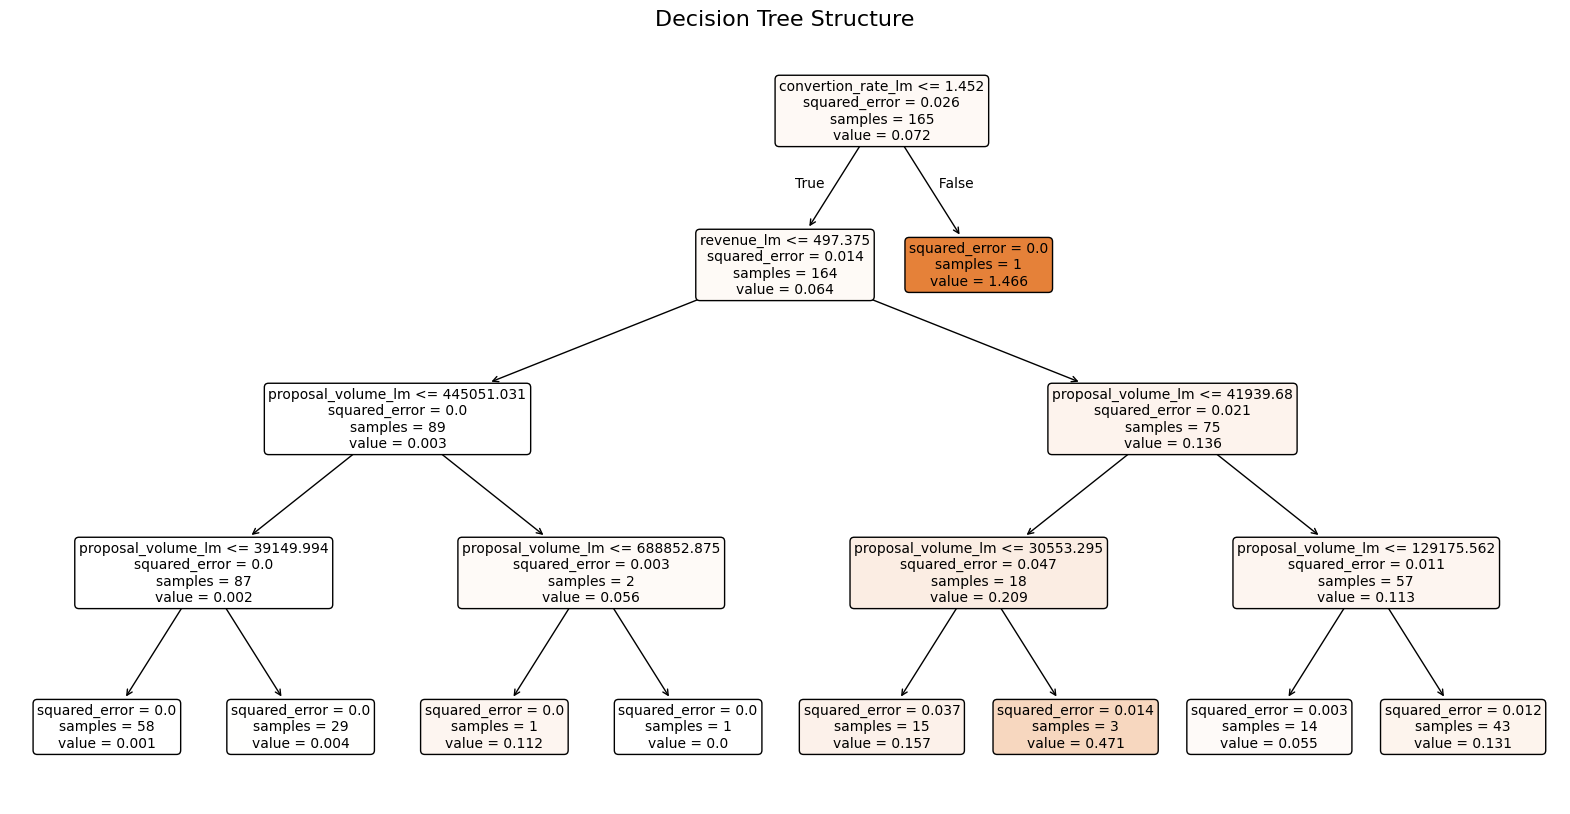

In [71]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(
    model, 
    feature_names=X_train.columns,  # feature names
    filled=True,                    # Color nodes by class/values
    rounded=True,                   # Rounded node borders
    max_depth=5,                    # Limit depth for readability
    fontsize=10
)
plt.title("Decision Tree Structure", fontsize=16)
plt.show()

O modelo apresentado no gráfico acima nos apresenta um avanço eficiente na qualidade das decisões a serem tomadas no futuro pelos stake holders, ainda existem muitas coisas a serem desenvolvidas e trabalhadas.

O modelo está dependendo muito do volume de propostas, o que pode nos indicar que as outras variáveis não tenham tanta importância assim. No entanto, as decisões ao olhadas juntos do meu gestor, são realistas, agora falta entendermos a aplicabilidade e como podemos melhorar.

In [72]:
importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

print(importance)

              Feature  Importance
1  convertion_rate_lm    0.626413
0          revenue_lm    0.230365
3  proposal_volume_lm    0.143222
2         goal_met_lm    0.000000


Mostra o quanto o modelo depende de cada feature, convertion_rate_lm tem uma taxa de importância alta, por isso foi a primeira varíavel a ser selecionada. O volume de proposta ser de baixa importância mas ter um uso repetido pela árvore de decisão me preocupa um pouco.

In [ ]:
from sklearn.tree import export_text

tree_rules = export_text(
    model, 
    feature_names=list(X_train.columns),   
    max_depth=3                          
)
print(tree_rules)

|--- proposal_volume_lm <= 2180977.44
|   |--- proposal_volume_lm <= 423288.81
|   |   |--- proposal_volume_lm <= 129175.56
|   |   |   |--- proposal_volume_lm <= 50503.76
|   |   |   |   |--- value: [15223.62]
|   |   |   |--- proposal_volume_lm >  50503.76
|   |   |   |   |--- value: [86965.23]
|   |   |--- proposal_volume_lm >  129175.56
|   |   |   |--- proposal_volume_lm <= 222057.32
|   |   |   |   |--- value: [164916.68]
|   |   |   |--- proposal_volume_lm >  222057.32
|   |   |   |   |--- value: [289105.65]
|   |--- proposal_volume_lm >  423288.81
|   |   |--- proposal_volume_lm <= 955525.38
|   |   |   |--- proposal_volume_lm <= 664869.25
|   |   |   |   |--- value: [551378.06]
|   |   |   |--- proposal_volume_lm >  664869.25
|   |   |   |   |--- value: [821531.44]
|   |   |--- proposal_volume_lm >  955525.38
|   |   |   |--- value: [1313976.60]
|--- proposal_volume_lm >  2180977.44
|   |--- value: [5027248.58]



Descritivo das regras do modelo em texto, nos ajuda a entender mais do cenário atual.